## Mounting

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports Here

In [0]:
import torch

In [0]:
import PIL
print(PIL.PILLOW_VERSION)

4.0.0


## Building the MODEL

In [0]:
# License: BSD
# Author: Chanchal Kumar Maji

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/Kaggle/dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) 
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
dataset_sizes

{'train': 11432, 'val': 3812}

In [0]:
class_names

['0', '1']

In [0]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 11432
     Root Location: /content/drive/My Drive/Kaggle/dataset/train
     Transforms (if any): Compose(
                              RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                              RandomHorizontalFlip(p=0.5)
                              ToTensor()
                              Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                          )
     Target Transforms (if any): None, 'val': Dataset ImageFolder
     Number of datapoints: 3812
     Root Location: /content/drive/My Drive/Kaggle/dataset/val
     Transforms (if any): Compose(
                              Resize(size=256, interpolation=PIL.Image.BILINEAR)
                              CenterCrop(size=(224, 224))
                              ToTensor()
                              Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    

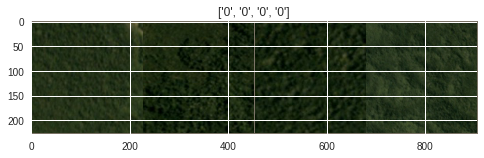

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training the MODEL

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Transfer Learning

In [0]:
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
model_ft.fc

Linear(in_features=2048, out_features=2, bias=True)

In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.0994 Acc: 0.9732
val Loss: 0.0352 Acc: 0.9892

Epoch 1/4
----------
train Loss: 0.0708 Acc: 0.9822
val Loss: 0.0652 Acc: 0.9785

Epoch 2/4
----------
train Loss: 0.0590 Acc: 0.9838
val Loss: 0.0346 Acc: 0.9885

Epoch 3/4
----------
train Loss: 0.0561 Acc: 0.9852
val Loss: 0.0321 Acc: 0.9898

Epoch 4/4
----------
train Loss: 0.0504 Acc: 0.9864
val Loss: 0.0626 Acc: 0.9798

Training complete in 89m 57s
Best val Acc: 0.989769


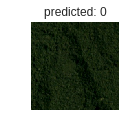

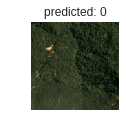

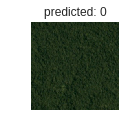

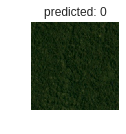

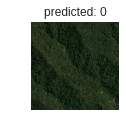

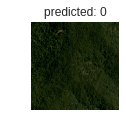

In [0]:
visualize_model(model_ft)

## Final accuracy on 'val' set

In [0]:
model_ft.eval()

accuracy = 0

for inputs, labels in dataloaders['val']:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model_ft(inputs)
    
    # Class with the highest probability is our predicted class
    equality = (labels.data == outputs.max(1)[1])

# Accuracy is number of correct predictions divided by all predictions
    accuracy += equality.type_as(torch.FloatTensor()).mean()
    
print("Test accuracy: {:.7f}".format(accuracy/len(dataloaders['val'])))

Test accuracy: 0.9897692


## Saving and Loading Models

In [0]:
model_ft.class_to_idx = image_datasets['train'].class_to_idx

checkpoint = {'input_size': model_ft.fc.in_features,
              'output_size': 2,
              'epochs': 25,    #
              'batch_size': 4,
              'model': models.resnet18(pretrained=True),    #
              'classifier': model_ft.fc,    #
              'scheduler': exp_lr_scheduler,
              'optimizer': optimizer_ft.state_dict(),    #
              'state_dict': model_ft.state_dict(),    #
              'class_to_idx': model_ft.class_to_idx    #
             }
   
torch.save(checkpoint, '/content/drive/My Drive/Kaggle/checkpoint1.pth')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 85095396.32it/s]


## Performing on Test Data

In [0]:
import pandas as pd

df = pd.read_csv('drive/My Drive/Kaggle/SampleSubmission.csv')

In [0]:
import os

files = os.listdir('drive/My Drive/Kaggle/TEST/')

In [0]:
len(files)

6534

In [0]:
from PIL import Image
from pathlib import Path

In [0]:
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [0]:
d = {}

In [0]:
model_ft.eval()

c = 0
for f in files:
    image = Image.open(Path('drive/My Drive/Kaggle/TEST/'+f))
    image = trans(image)
    reshaped = image.view(1, 3, 224, 224)
    output = model_ft(reshaped.to(device))
    a = torch.exp(output[0][0])
    b = torch.exp(output[0][1])
    p = b / (a+b)
    d[f] = p
    
    c += 1
    if c % 100 == 0:
        print(c)

RuntimeError: ignored

In [0]:
c == len(d)

In [0]:
prob = []
for index, row in df.iterrows():
    #print(row['image_id'], row['has_oilpalm'])
    key = row['image_id']
  
    p = d[key]
        
    prob.append(p.cpu().detach().numpy())

In [0]:
prob[:10]

In [0]:
ans = pd.Series(prob)

d = pd.read_csv('drive/My Drive/Kaggle/SampleSubmission.csv')
d['has_oilpalm'] = ans
d.head(11)

In [0]:
d.to_csv('drive/My Drive/Kaggle/submission1.csv', index=False)